# Heuristic 1 Notebook

This notebook will walk you through the implementation of heuristic 1.

<br/>


In [1]:
import os
import time
from concurrent.futures import ProcessPoolExecutor

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance

from src.utils.construct_map import construct_map
from src.utils.tsp_solver import k_opt
from src.visualization.paths_and_subtours import visualize_subtours
from src.visualization.visualization_pipeline import run_visualization_pipeline

## 0. Specify problem parameters

<br/>

Here, specify the problem parameters according to the below table. Heuristic 1 consists of five steps. If you want to skip the optional step three, set `skip_tsp_optimization` to `True`.

<br/>

| Python Variable | LaTex Variable                   | Parameter Description                                                          |
|:----------------|:---------------------------------|:-------------------------------------------------------------------------------|
| `k`             | $k$                              | Number of Robots                                                               |
| `n`             | $n$                              | Number of Discrete Nodes to Place Per Axis                                     |
| `ssd`           | $SSD$                            | Length of each side of the square                                              |
| `d`             | $D$                              | Length of distance between the outermost nodes of each axis                    |
| `rp`            | $r$                              | Redundancy Parameter (Each node must be visited at list `rp` different robots) |
| `L_min`         | $L_\text{min-required-capacity}$ | Minimum Required Fuel to Cover the Area                                        |
| `L`             | $L_\text{max-capacity}$          | Maximum Fuel Capacity of Each Robot (We usually set this as a factor of L_min) |

<br/>


$R_\text{surveillance}$ is calculated by the following equation.

<p style="text-align: center;">$R_\text{surveillance} = \frac{SSD}{\sqrt{2} n}$</p>

<br/>

We can calculate $D$ with using $R_\text{surveillance}$ because the corners and edges of the whole arena need not be covered. Use the following equation to update $D$. This becomes the distance between the outermost nodes in each axis.

<p style="text-align: center;">$D = SSD - \sqrt{2}R_\text{surveillance}$</p>

<br/>

`L_min` is given by $2\sqrt{2}D$  (equation 5 in the report).


In [2]:
# Chose number of robots
k = 8
# Chose the number of targets in an axis (NOT NUMBER OF TOTAL NODES)
n = 8  # 64 nodes in total
# Chose the length of distance of each side of the square arena
ssd = 3.
# Chose the length of distance between the outermost nodes of each axis
sr = ssd / (np.sqrt(2.) * n)
d = ssd - np.sqrt(2.) * sr
# Choose the redundancy parameter (have each target be visited by exactly that many robots)
rp = min(3, k)
# Fuel Capacity Parameters
max_fuel_cost_to_node = d * np.sqrt(2)  # 3√2 is the max possible distance between our nodes (-1.5, -1.5) and (1.5, 1.5)
L_min = max_fuel_cost_to_node * 2  # Minimum required capacity is equal to the cost of the tour that only travels between the depot and the farthest node
L = L_min * 1.5  # Fuel capacity (1 unit of fuel = 1 unit of distance)

skip_tsp_optimization = False

## 1. Create map and get node indices

<br/>

The function `construct_map` creates a map with a total of 65 nodes, 64 targets and 1 depot. 


In [3]:
# 1. Create map and get node indices
start = time.time()
nodes, node_indices, target_indices, depot_indices = construct_map(n, ssd, d, gfx_sanity_check=False)
print(f"Constructing the map took {time.time() - start} seconds.")

Constructing the map took 0.0011320114135742188 seconds.


## 2. Calculate cost between each node

<br/>

Create a 65x65 cost matrix to later provide $O(1)$ lookup for cost between nodes.


In [4]:
# 2. Calculate cost between each node
start = time.time()
cost = distance.cdist(nodes, nodes, 'euclidean')
print(f"Constructing the cost matrix took {time.time() - start} seconds.")

Constructing the cost matrix took 6.723403930664062e-05 seconds.


## 3. Solve for given parameters
---

<br/>

Now that the setup is done, start solving the problem here. Heuristic 1 consists of five steps, of which one (step three) is optional.

<br/>

### 3.1 Step 1: Sort the node indices

<br/>

In step one, sort the nodes to be visited based on angle (higher-priority) and distance (only if angle values are same) between nodes and the depot point. 

Step 1 took 0.00047898292541503906 seconds.


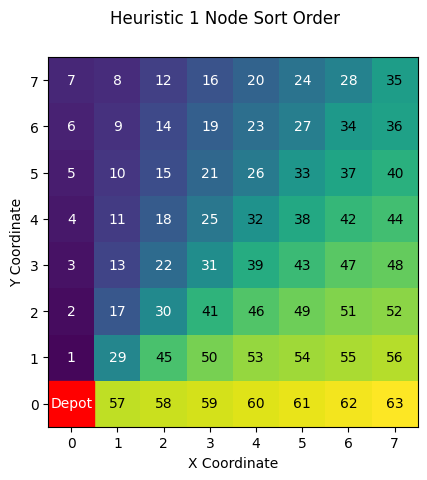

In [5]:
def step_one_solve(nodes, target_indices, depot_indices, cost):
    heading_values = []
    for n_i in target_indices:
        v1 = nodes[n_i]
        v2 = nodes[depot_indices[0]]
        heading = np.arctan2(*(v1 - v2)) % (2 * np.pi)
        heading_values.append(heading)
    heading_values = np.array(heading_values)
    nodes_costs = cost[:depot_indices[0], depot_indices[0]]
    sorted_indices = np.lexsort((nodes_costs, heading_values))
    # for i, ni in enumerate(sorted_indices):
    #     print(f"{i=} {ni=} {heading_values[ni]=} {nodes_costs[ni]=}")
    return sorted_indices


def step_one_visualize(n, sorted_indices):
    sort_map = np.zeros((n, n))
    for i, ni in enumerate(sorted_indices):
        sort_map[int(np.floor(ni / n)), int(ni) % n] = i
    fig, ax = plt.subplots()
    plt.imshow(sort_map.T, origin='lower')
    ax.add_patch(plt.Rectangle((-0.5, -0.5), 1, 1, color='r'))
    plt.text(0, 0, "Depot", ha="center", va="center", color="w")
    for (i, j), label in np.ndenumerate(sort_map):
        if i == j == 0: continue
        tc = "white" if sort_map[i, j] < sort_map.mean() else "black"
        plt.text(i, j, f"{int(sort_map[i, j])}", ha="center", va="center", color=tc)
    fig.suptitle("Heuristic 1 Node Sort Order")
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()


# Step 1: sort the node indices for creating subtours
start = time.time()
sorted_indices = step_one_solve(nodes, target_indices, depot_indices, cost)
print(f"Step 1 took {time.time() - start} seconds.")
# Visualization
step_one_visualize(n, sorted_indices)

### 3.2 Step 2: Group nodes into subtours

<br/>

In this step, we split the list of nodes into at most `k` subtours such that the cost of any subtour is minimized.
We do this by iterating through nodes based on the ordering from the previous step and adding nodes to subtours if the subtours can still satisfy the fuel constraint of `L_curr`, and starting a new subtour if it can not. The algorithm checks for new node insertion based on the minimum cost increase of the tour (also called cheapest insertion). `L_curr` is constrained to `L_min` and `L` and initialized to `L_min`. The algorithm bounces between these constraints to find at most `k` subtours.

<br/>

In this case the algorithm found 5 subtours, where the maximum costing subtour's cost is `L_min`. 


In [6]:
def divideArrayByP(maxp, countf, low, high, force_p_equals=False):
    # condition = True
    maxSum = low
    maxSum_max = high
    maxSum_min = low
    err_thresh = 0.01
    best_p, best_p_a, best_p_c, best_max_p_c = np.inf, None, [np.inf], np.inf
    # print(f"{best_p=}")
    # Ensure maxp is big enough
    while True:
        p, p_a, p_c, max_p_c = countf(high, maxp)
        if p == np.inf:
            maxp += 1
        else:
            break

    # Try to reduce maxSum now (cost of each subtour)
    while True:
        p, p_a, p_c, max_p_c = countf(maxSum, maxp)
        # print(f"2 {maxp=} {best_p=} {maxSum=} {maxSum_min=} {maxSum_max=}")
        # If we can't divide it to the number of robots we have, increase by one
        if best_p == np.inf and maxSum_max - maxSum_min < err_thresh:
            maxp += 1
            maxSum = low
            maxSum_min = low
            maxSum_max = high

        if p > maxp:
            maxSum_min = maxSum
        elif p <= maxp:
            maxSum_max = min(max_p_c, maxSum_max)
            maxSum = max_p_c

        if (force_p_equals and maxp >= p and max_p_c <= best_max_p_c) or (not force_p_equals and p <= best_p):
            best_p = p
            best_p_a = p_a
            best_p_c = p_c
            best_max_p_c = max_p_c

        # print(f"{p=} {best_p=} {maxSum=} {maxSum_min=} {maxSum_max=} {maxSum_max - maxSum_min=} {max_p_c=} {p_c=}")
        # print(f"{p=} {p_a=} {p_c=}")
        # time.sleep(0.5)

        if best_p <= maxp and maxSum_max - maxSum_min < err_thresh:
            return best_p_a, best_p_c, maxSum

        if p > maxp and maxSum <= high:
            delta = maxSum_max - maxSum
            maxSum = maxSum + delta / 2.
        else:
            delta = maxSum - maxSum_min
            maxSum = maxSum - delta / 2.

Step 2: Found 7 subtours.
Step 2 took 0.0005979537963867188 seconds.


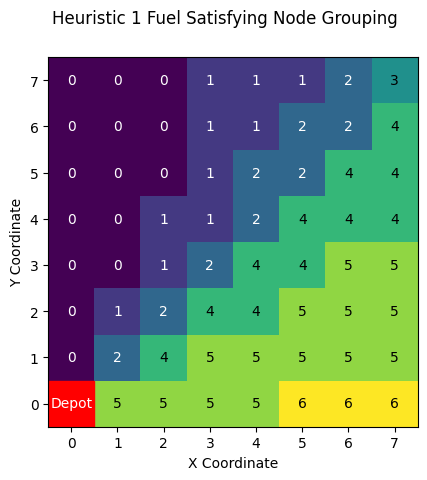

In [7]:
def step_two_solve(k, L_min, L, depot_indices, cost, sorted_indices):
    # https://takeuforward.org/arrays/split-array-largest-sum/
    def countSubtourPartitions(maxSum, maxp):
        # n = len(a)  # size of array
        partitions = 1
        partitions_array = [[depot_indices[0], depot_indices[0]]]
        partitions_cost = []
        max_partitions_cost = 0
        for i, n_i in enumerate(sorted_indices):
            node_addition_index = 1
            node_addition_cost = np.inf
            subarraySum = 0
            for j, n_j in enumerate(partitions_array[partitions - 1][:-1]):
                n_k = partitions_array[partitions - 1][j + 1]
                edge_cost = cost[n_j, n_k]
                subarraySum += edge_cost
                new_edge_cost = cost[n_j, n_i] + cost[n_i, n_k]
                if new_edge_cost - edge_cost < node_addition_cost:
                    node_addition_cost = new_edge_cost - edge_cost
                    node_addition_index = j + 1

            if subarraySum + node_addition_cost >= maxSum:
                # if not, insert element to next subarray
                partitions += 1
                if partitions > maxp:
                    # print(f"\tearly stopping...")
                    return np.inf, None, None, np.inf

                partitions_cost.append(subarraySum)
                max_partitions_cost = max(max_partitions_cost, subarraySum)
                node_addition_index = 1
                partitions_array.append([depot_indices[0], depot_indices[0]])
            partitions_array[partitions - 1].insert(node_addition_index, n_i)
            # print(f"{partitions_array[partitions-1]}")

        if len(partitions_array) != len(partitions_cost):
            subarraySum = 0
            for j, n_j in enumerate(partitions_array[partitions - 1][:-1]):
                n_k = partitions_array[partitions - 1][j + 1]
                subarraySum += cost[n_j, n_k]
            partitions_cost.append(subarraySum)
            max_partitions_cost = max(max_partitions_cost, subarraySum)

        return partitions, partitions_array, partitions_cost, max_partitions_cost

    tsp_subtours, tsp_costs, maxSum = divideArrayByP(k, countSubtourPartitions, low=L_min, high=L)
    # print(f"{L=}")
    # print(f"{len(tsp_subtours)=} {maxSum=}")
    # print(f"{distributed_nodes_indices=}")
    # print(f"{tsp_upper_bound=}")
    # visualize_subtours(tsp_subtours, {"n_a": n, "ssd": d, "is_subtour": True})
    print(f"Step 2: Found {len(tsp_subtours)} subtours.")
    return tsp_subtours, tsp_costs, maxSum


def step_two_visualize(n, tsp_subtours):
    node_partition_map = np.zeros((n, n))
    for c, si in enumerate(tsp_subtours):
        for i, ni in enumerate(si):
            if ni == 64: continue  # Depot
            node_partition_map[int(np.floor(ni / n)), int(ni) % n] = c
    fig, ax = plt.subplots()
    pos = plt.imshow(node_partition_map.T, origin='lower')
    ax.add_patch(plt.Rectangle((-0.5, -0.5), 1, 1, color='r'))
    plt.text(0, 0, "Depot", ha="center", va="center", color="w")
    for (i, j), label in np.ndenumerate(node_partition_map):
        if i == j == 0: continue
        tc = "white" if node_partition_map[i, j] < node_partition_map.mean() else "black"
        plt.text(i, j, f"{int(node_partition_map[i, j])}", ha="center", va="center", color=tc)

    fig.suptitle("Heuristic 1 Fuel Satisfying Node Grouping")
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.show()


# Step 2: Divide nodes to subtours s.t. cost <= L
start = time.time()
tsp_subtours, tsp_costs, maxSum = step_two_solve(k, L_min, L, depot_indices, cost, sorted_indices)
print(f"Step 2 took {time.time() - start} seconds.")
# Visualization
step_two_visualize(n, tsp_subtours)

### 3.3 Step 3: Optionally run a TSP solver on each subtour

<br/>

In this optional step, the algorithm goes through each subtour and run the k-opt algorithm on the nodes. This implementation runs the TSP solver in parallel, using multiple cores of the CPU.


	[subtour 2/7] took 0.413 seconds and improved 3.954%.
	[subtour 4/7] took 0.450 seconds and improved 0.000%.
	[subtour 6/7] took 0.450 seconds and improved 6.295%.
	[subtour 1/7] took 0.450 seconds and improved 4.269%.
	[subtour 5/7] took 0.450 seconds and improved 0.803%.
	[subtour 3/7] took 0.450 seconds and improved 0.000%.
	[subtour 7/7] took 0.560 seconds and improved 0.000%.
Step 3 took 0.6207947731018066 seconds.
	Visualizing subtours for heuristic 1 or MILP...


7it [00:00, 45.68it/s]


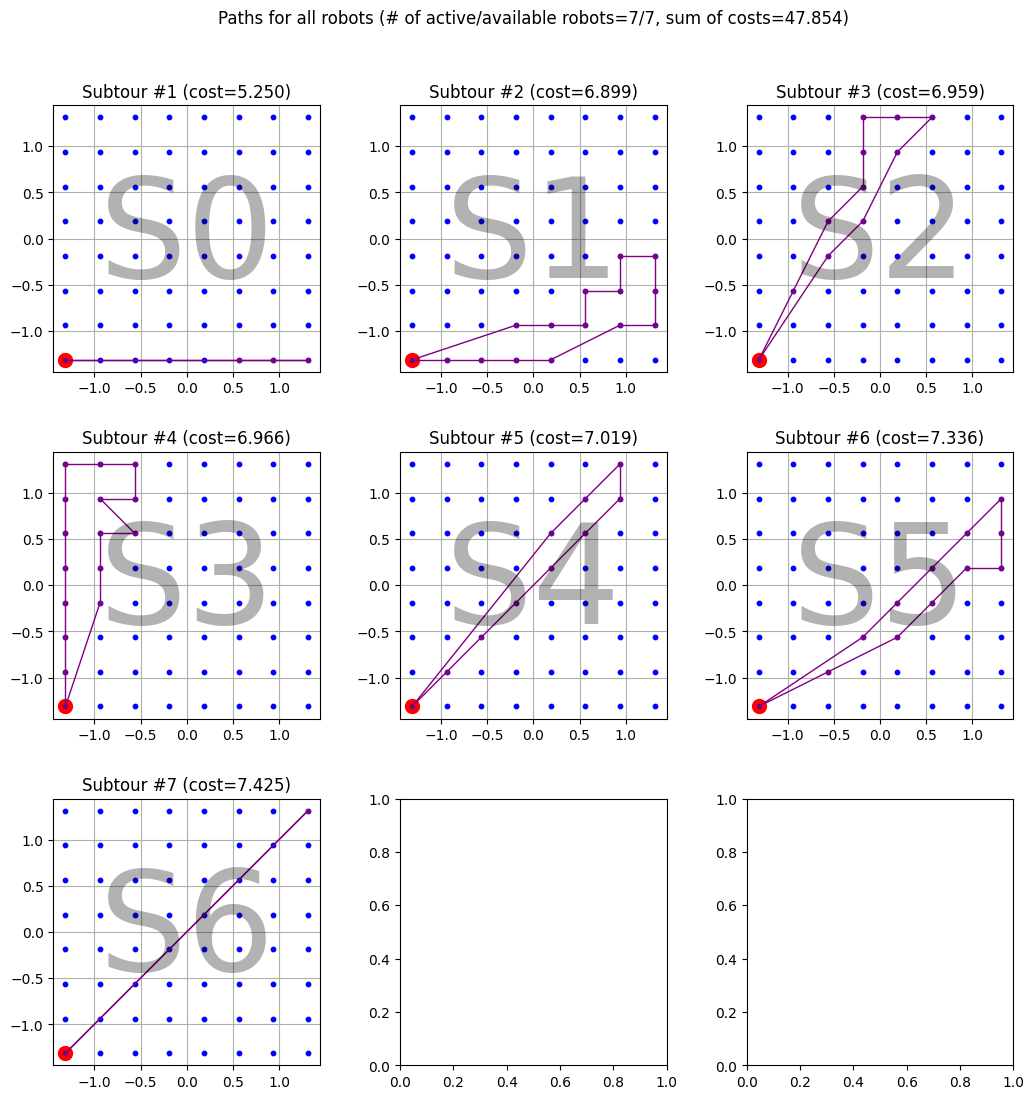

In [8]:
def step_three_solve(cost, tsp_subtours, tsp_costs):
    start = time.time()
    tsp_subtours_prev, tsp_costs_prev = tsp_subtours, tsp_costs
    tsp_subtours = []
    tsp_costs = []
    with ProcessPoolExecutor(max_workers=os.cpu_count() - 1) as executor:
        futures = []
        for heur_subtour in tsp_subtours_prev:
            futures.append(executor.submit(k_opt, *[heur_subtour, cost, 2]))

        uncompleted_jobs = list(range(len(futures)))
        while len(uncompleted_jobs) != 0:
            new_uncompleted_jobs = uncompleted_jobs
            for future_i in uncompleted_jobs:
                if futures[future_i].done():
                    best_subtour, c = futures[future_i].result()
                    print(f"\t[subtour {future_i + 1}/{len(futures)}] took {time.time() - start:.3f} seconds and improved {(1 - c / tsp_costs_prev[future_i]) * 100:.3f}%.")
                    tsp_subtours.append(best_subtour)
                    tsp_costs.append(c)
                    new_uncompleted_jobs.remove(future_i)
                else:
                    time.sleep(0.1)
            uncompleted_jobs = new_uncompleted_jobs
    return tsp_subtours, tsp_costs


def step_three_visualize(n, ssd, d, tsp_subtours, tsp_indices):
    visualize_subtours([tsp_subtours[tsp_indices[si]] for si in range(len(tsp_subtours))],
                       metadata={"n_a": n, "ssd": ssd, "ssd_discrete": d, "is_subtour": True})


# Step 3: Further optimize the subtours by running tsp on them
if skip_tsp_optimization:
    print(f"Skipping TSP optimization ...")
else:
    start = time.time()
    tsp_subtours, tsp_costs = step_three_solve(cost, tsp_subtours, tsp_costs)
tsp_indices = np.array(tsp_costs).argsort().tolist()
print(f"Step 3 took {time.time() - start} seconds.")
# Visualization
step_three_visualize(n, ssd, d, tsp_subtours, tsp_indices)

### 3.4 Step 4: Introduce Redundancy

<br/>

In this step, the algorithm multiplies each subtour by at least `rp` times. This makes sure that each node is visited at least `rp` times. When the number of robots is too high, sometimes not all robots can be assigned a subtour. To prevent this, we increase `rp` such that each robot is assigned at least one subtour. The update law is as follows.

<br/>

<p style="text-align: center;">$r = max(r, \lceil \frac{k}{|Subtours|} \rceil)$</p>


In [9]:
def step_four_solve(k, rp, tsp_subtours, tsp_indices, tsp_costs):
    num_of_subtours = len(tsp_subtours)
    rp = max(int(np.ceil(k / num_of_subtours)), rp)  # Ensure that each robot is assigned at least one subtour
    for i in range(num_of_subtours, int(num_of_subtours * rp)):
        tsp_subtours.append(tsp_subtours[i % num_of_subtours])
        tsp_indices.append(i)
        tsp_costs.append(tsp_costs[i % num_of_subtours])
    return tsp_subtours, tsp_indices, tsp_costs


# Step 4: Ensure rp
start = time.time()
tsp_subtours, tsp_indices, tsp_costs = step_four_solve(k, rp, tsp_subtours, tsp_indices, tsp_costs)
print(f"Step 4 took {time.time() - start} seconds.")

Step 4 took 3.790855407714844e-05 seconds.


### 3.5 Step 5: Assign the resulting subtours to robots

<br/>

Using a similar approach to one used in step 2, we assign list of subtours to each robot with the objective of minimizing the maximal cost of path (sum of subtour costs) assigned to any robot.


In [10]:
def step_five_solve(k, nodes, tsp_subtours, tsp_indices, tsp_costs, metadata):
    def countRobotPartitions(maxSum, maxp):
        # n = len(a)  # size of array
        partitions = 1
        subarraySum = 0
        partitions_array = [[]]
        partitions_cost = []
        max_partitions_cost = 0
        for i in tsp_indices:
            if subarraySum + tsp_costs[i] <= maxSum:
                # insert element to current subarray
                subarraySum += tsp_costs[i]
            else:
                # if not, insert element to next subarray
                partitions += 1
                if partitions > maxp:
                    # print(f"\tearly stopping...")
                    return np.inf, None, None, np.inf

                partitions_cost.append(subarraySum)
                max_partitions_cost = max(max_partitions_cost, subarraySum)
                subarraySum = tsp_costs[i]
                partitions_array.append([])
            partitions_array[partitions - 1].append(tsp_subtours[i])

        if len(partitions_array) != len(partitions_cost):
            partitions_cost.append(subarraySum)
            max_partitions_cost = max(max_partitions_cost, subarraySum)

        return partitions, partitions_array, partitions_cost, max_partitions_cost

    opt_node_paths, opt_node_path_costs, maxSum = divideArrayByP(k, countRobotPartitions, low=max(tsp_costs),
                                                                 high=sum(tsp_costs), force_p_equals=True)
    # for i, optimized_node_path in enumerate(opt_node_paths):
    #     print(f"[{i}] {len(optimized_node_path)=} cost=({optimized_node_path_costs[i]})")
    # print(f"{sum(opt_node_path_costs)=} {max(opt_node_path_costs)=}")
    metadata["opt_node_path_costs"] = opt_node_path_costs
    opt_world_paths = []
    for ki in range(min(k, len(opt_node_paths))):
        robot_world_path = []
        for i, subtour in enumerate(opt_node_paths[ki]):
            # print(f"Assigned subtour {i} to robot {ki}")
            robot_world_path.append(nodes[subtour].tolist())
        opt_world_paths.append(robot_world_path)
    metadata["k"] = min(k, len(opt_node_paths))
    return opt_node_paths, opt_world_paths, metadata


# Step 5: Divide subtours between robots
start = time.time()
opt_node_paths, opt_world_paths, metadata = step_five_solve(k, nodes, tsp_subtours, tsp_indices, tsp_costs, {})
print(f"Step 5 took {time.time() - start} seconds.")

Step 5 took 0.00028014183044433594 seconds.


## Finally, visualize the solution

<br/>

We visualize the paths assigned to each robot, a visitation heatmap, and percentage of coverage over time.

Running visualization pipeline...
	Visualizing paths for heuristic 1 or MILP...


8it [00:00, 43.58it/s]


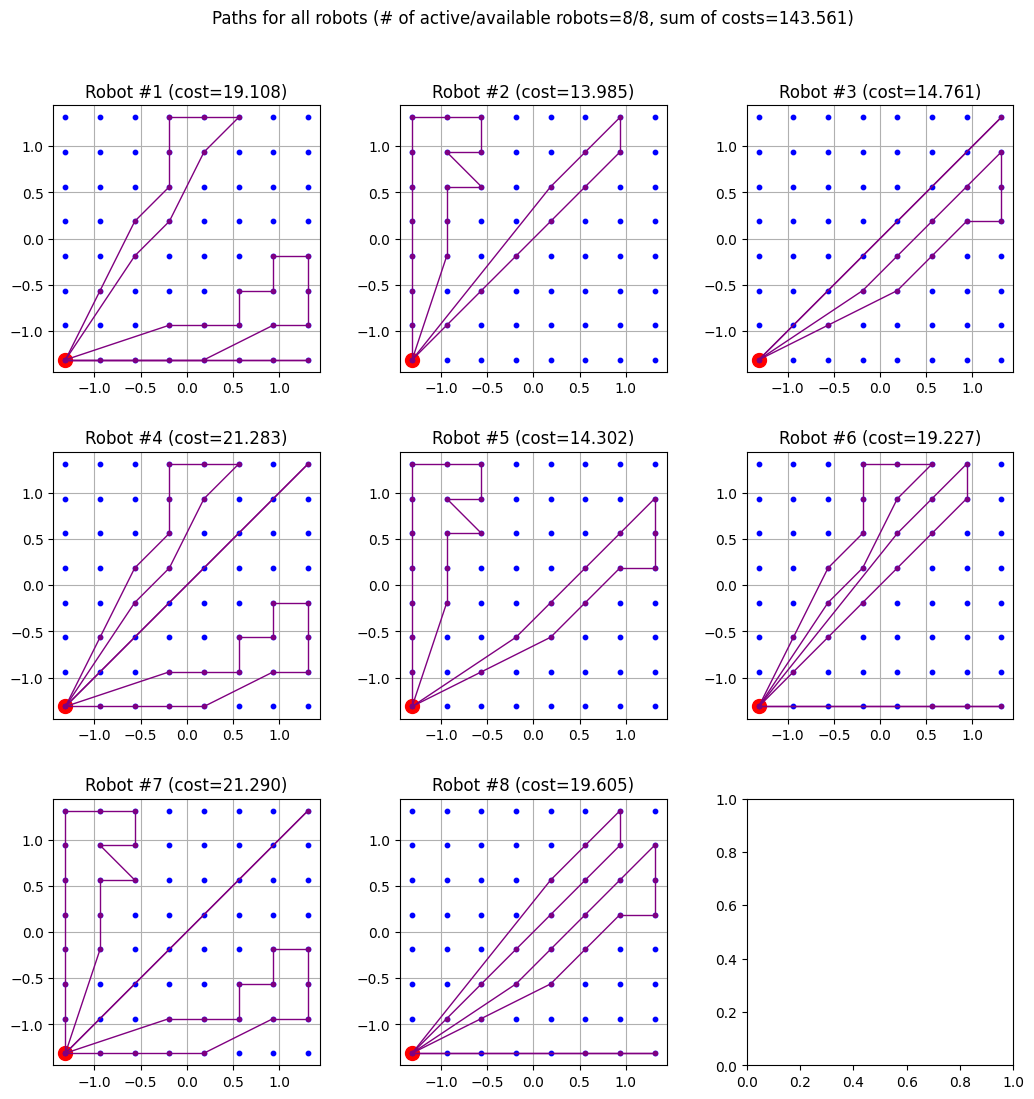

	Visualizing visitation heatmap...


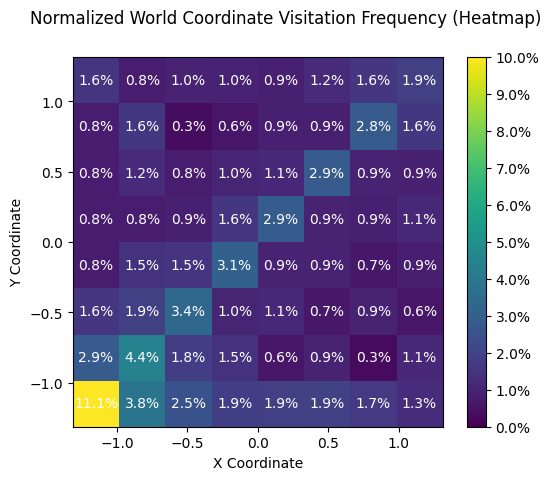

	Visualizing coverage over time...


100%|██████████| 36001/36001 [01:11<00:00, 501.22it/s]

average_coverage=77.1014944800916


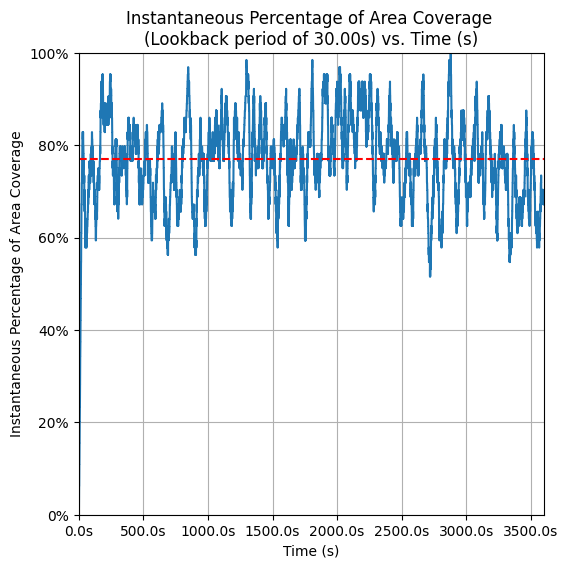

Visualizations complete! Returning metadata...


{'opt_node_path_costs': [19.108028074781554,
  13.984996484609656,
  14.76073442922205,
  21.282649277240303,
  14.302297435216353,
  19.227460736812592,
  21.290185025037363,
  19.604925502919905],
 'k': 8,
 'mode': 'h1',
 'v': 0.2,
 't': 3600.0,
 'dt': 0.1,
 'lookback_time': 30.0,
 'n_a': 8,
 'ssd': 3.0,
 'ssd_discrete': 2.625,
 'average_coverage': 77.1014944800916}

In [11]:
metadata["mode"] = "h1"
metadata["v"] = 0.2
metadata["t"] = 3600.
metadata["dt"] = 0.1
metadata["lookback_time"] = 30.
metadata["n_a"] = n
metadata["ssd"] = ssd
metadata["ssd_discrete"] = d
run_visualization_pipeline(opt_node_paths, opt_world_paths, metadata)